In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import autograd.numpy as np
import celerite
from celerite import terms
from celerite import GP
from scipy.optimize import minimize

In [2]:
import autograd.numpy as np
import celerite
from celerite import terms
from celerite import GP
from scipy.optimize import minimize

class DRW_kernel(terms.Term):
    # build a Damped Random Walk kernel, a means the standard variance, c means the characteristic timescale
    
	parameter_names = ("log_a", "log_c")
	
	def get_real_coefficients(self, params):
		log_a, log_c = params
        
		return np.exp(log_a)**2, 1.0/np.exp(log_c)

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

def GP_lc(mjd, band, band_err, sigma_in, tau_in):
    
    print("True SF infinte: ", sigma_in*np.sqrt(2))
    print("True Tau: ", tau_in)
    
    sigma_bounds = [0.01, 1.0]
    tau_bounds = [1,10000]
    bounds = dict(log_a = np.log(sigma_bounds), log_c = np.log(tau_bounds))
    
    kernel = DRW_kernel(log_a = np.log(sigma_in), log_c = np.log(tau_in), bounds = bounds)
    gp = GP(kernel, mean=np.mean(band))
    gp.compute(mjd, band_err)  

    print("Initial log likelihood: {0}".format(gp.log_likelihood(band)))  
    print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
    print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
    print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
    print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))
    
    #find the maximum likelihood parameters for this model
    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()
    soln = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(band, gp))
    gp.set_parameter_vector(soln.x)
    
    print(soln)
    
    a_out = gp.get_parameter_dict()['kernel:log_a']
    c_out = gp.get_parameter_dict()['kernel:log_c']
    SF_inft = np.sqrt(2)*np.exp(a_out)
    tau_out = np.exp(c_out)
    
    print("Estimated SF infinte: ", SF_inft)
    print("Estimated Tau: ", tau_out)
    
    return gp

def predict_lc(gp, mjd, band_name, band, band_err):
    continuous_mjd = np.linspace(min(mjd),max(mjd), max(mjd)-min(mjd))
    pred_mean, pred_var = gp.predict(band, continuous_mjd, return_var=True)
    pred_std = np.sqrt(pred_var)
    
    #plot the predicted light curve
    color = "#ff7f0e"
    plt.figure(figsize = (20,10))
    plt.errorbar(mjd, band, yerr=band_err, fmt=".k", capsize=0)
    plt.plot(continuous_mjd, pred_mean, color=color)
    plt.fill_between(continuous_mjd, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none")
    plt.xlabel("mjd (days)",fontsize=20)
    plt.ylabel("flux",fontsize=20)
    plt.title(band_name+' band maximum likelihood prediction',fontsize=20)
    plt.show()
    
    return pred_mean, pred_std

In [3]:
def plot_lc(target):
    
    plt.figure(figsize = (20,10))
    plt.title('Object id: '+str(target_id))
    plt.errorbar(target['mjd'], target['u'], yerr = target['u_err'], alpha = 0.6,fmt='o',ecolor='blue',color='blue',elinewidth=2,capsize=3,ms=5,label = 'u')
    plt.errorbar(target['mjd'], target['g'], yerr = target['g_err'], alpha = 0.6,fmt='o',ecolor='green',color='green',elinewidth=2,capsize=3,ms=5,label = 'g')
    plt.errorbar(target['mjd'], target['r'], yerr = target['r_err'], alpha = 0.6,fmt='o',ecolor='r',color='r',elinewidth=2,capsize=3,ms=5,label = 'r')
    plt.errorbar(target['mjd'], target['i'], yerr = target['i_err'], alpha = 0.6,fmt='o',ecolor='orange',color='orange',elinewidth=2,capsize=3,ms=5,label = 'i')
    plt.errorbar(target['mjd'], target['z'], yerr = target['z_err'], alpha = 0.6,fmt='o',ecolor='black',color='black',elinewidth=2,capsize=3,ms=5,label = 'z')
    plt.errorbar(target['mjd'], target['y'], yerr = target['y_err'], alpha = 0.6,fmt='o',ecolor='purple',color='purple',elinewidth=2,capsize=3,ms=5,label = 'y')
    plt.legend(loc="upper right",fontsize=20)
    plt.xlabel("Time (days)",fontsize=20)
    plt.ylabel("Flux",fontsize=20)



In [4]:
def difference_lc(mjd, band):
    different_band = [0.0]
    n = 0
    while n<len(mjd)-1:
        different_band.append(band[n+1]-band[n])
        n +=1
    return different_band

In [17]:
file = '../data/training_converted.csv'
model_file = '../data/plasticc_modelpar_088_AGN.csv'
data = pd.read_csv(file)
model = pd.read_csv(model_file)

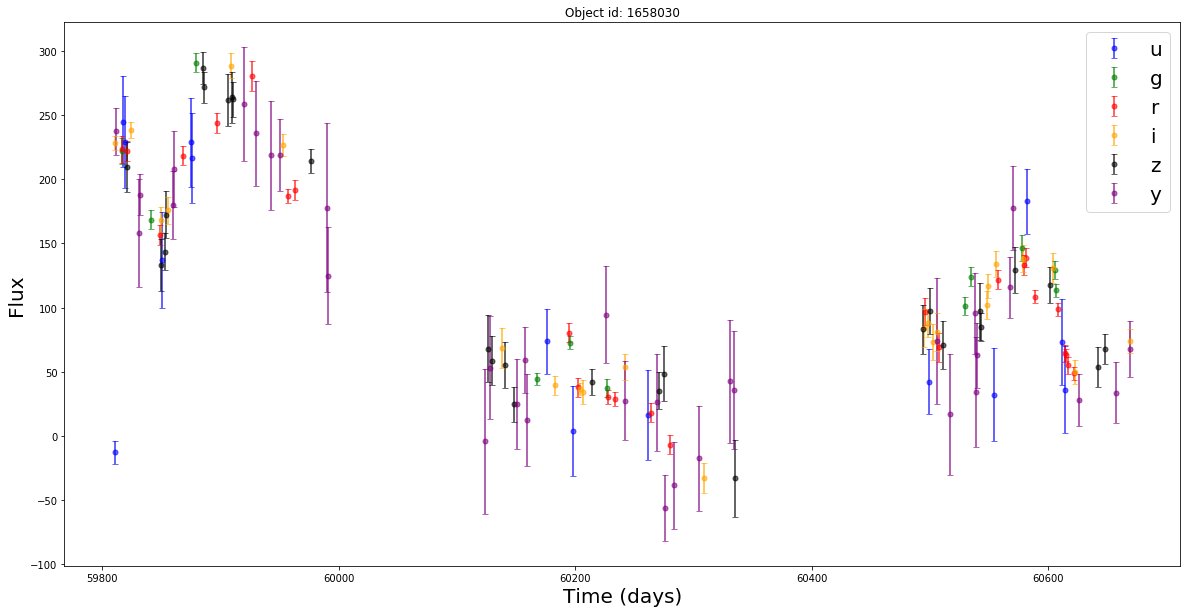

In [18]:
target_id = 1658030
target= data[(data.id==target_id)]
plot_lc(target)

In [19]:
target_model = model[(model.object_id == target_id)]
tau = float(target_model['TAU'])
SF_dict = {'u': float(target_model['SFU']), 'g':float(target_model['SFG']), 'r':float(target_model['SFR']), 'i': float(target_model['SFI']), 'z':float(target_model['SFZ']), 'y':float(target_model['SFY'])}
print('tau:', tau)
print('SF_dict:', SF_dict)

tau: 1651.24
SF_dict: {'u': 0.198, 'g': 0.176, 'r': 0.156, 'i': 0.142, 'z': 0.132, 'y': 0.124}


In [28]:
i = 'z'
target_band = target[['mjd',i,i+'_err']].dropna().reset_index()
mean_band = np.mean(target_band[i])
target_band[i] = target_band[i] - mean_band
# difference_band = difference_lc(target_band['mjd'], target_band[i])

In [29]:
# difference_band = np.array(difference_band)/250
# target_band[i] = target_band[i]/500
# target_band[i+'_err'] = target_band[i+'_err']/500

In [30]:
# plt.plot(target_band['mjd'],difference_band)
# plt.xlabel('mjd')
# plt.ylabel('flux (difference)')

In [31]:
gp = GP_lc(target_band['mjd'], target_band[i], target_band[i+'_err'], SF_dict[i]/np.sqrt(2), tau)
# pred_mean, pred_std = predict_lc(gp, target_band['mjd'], i, difference_band, target_band[i+'_err'])

True SF infinte:  0.132
True Tau:  1651.24
Initial log likelihood: -611.3606923802502
parameter_dict:
OrderedDict([('kernel:log_a', -2.371526946675739), ('kernel:log_c', 7.409281799800029)])

parameter_names:
('kernel:log_a', 'kernel:log_c')

parameter_vector:
[-2.37152695  7.4092818 ]

parameter_bounds:
[array([-4.60517019,  0.        ]), array([0.        , 9.21034037])]

      fun: 598.6415016737673
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.47243065e+01,  2.27373675e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 33
      nit: 5
   status: 0
  success: True
        x: array([0.        , 5.02626733])
Estimated SF infinte:  1.4142135623730951
Estimated Tau:  152.36322830863577


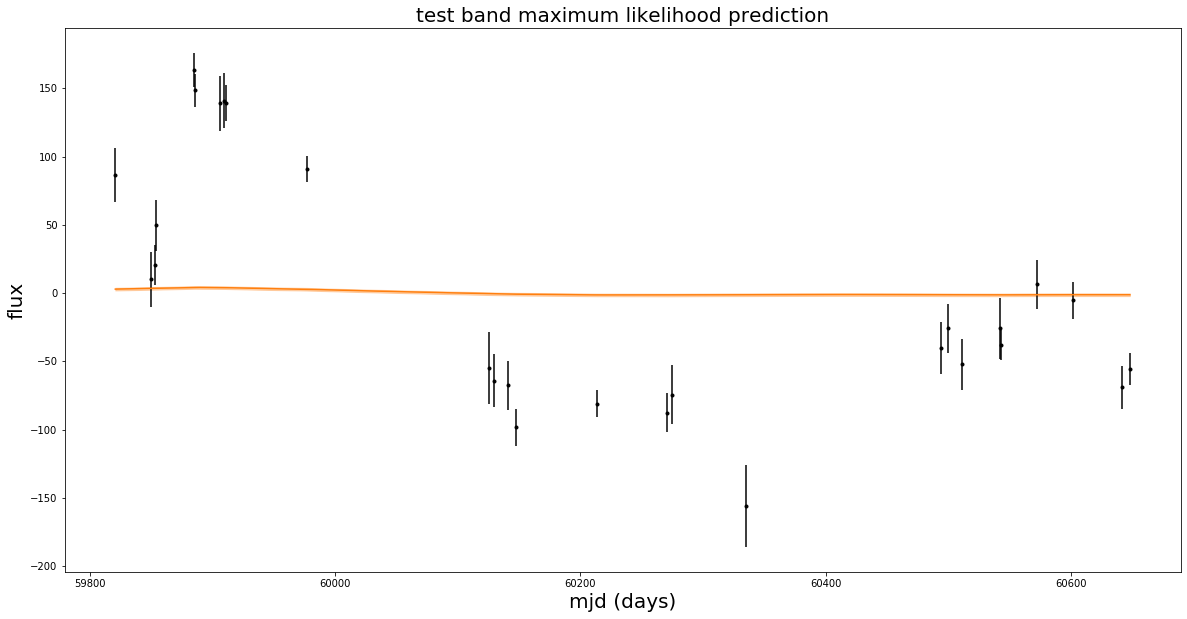

In [32]:
# test
mjd = target_band['mjd']
band = target_band[i]
band_err = target_band[i+'_err']
band_name = 'test'
continuous_mjd = np.linspace(min(mjd),max(mjd), max(mjd)-min(mjd))
pred_mean, pred_var = gp.predict(band, continuous_mjd, return_var=True)
pred_std = np.sqrt(pred_var)
#plot the predicted light curve
color = "#ff7f0e"
plt.figure(figsize = (20,10))
plt.errorbar(mjd, band, yerr=band_err, fmt=".k", capsize=0)
plt.plot(continuous_mjd, pred_mean, color=color)
plt.fill_between(continuous_mjd, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none")
plt.xlabel("mjd (days)",fontsize=20)
plt.ylabel("flux",fontsize=20)
plt.title(band_name+' band maximum likelihood prediction',fontsize=20)
plt.show()
    

In [51]:
# bands = ['u','g','r','i','z','y']

# for i in bands:
#     target_band = target[['mjd',i,i+'_err']].dropna()
#     sigma_in = SF_dict[i]/np.sqrt(2)
#     tau_in = tau

#     gp = GP_lc(target_band['mjd'], target_band[i], target_band[i+'_err'], sigma_in, tau_in)
#     predict_lc(gp, target_band['mjd'], i,target_band[i],target_band[i+'_err'] )
   

In [68]:
def calculate_obs_SF(mjd, flux):
    # structure function
    
    # convert mjd to integer
    mjd = mjd.astype(int).tolist()
    flux = flux.astype(float).tolist()
    #initialize the delta time
    delta = 1
    obs_SF_list = []
    delta_list = []
    obs_len = max(mjd) - min(mjd)
    while delta < obs_len:
        n = min(mjd)
        count = 0
        mag_vals = 0.0
        while n <= max(mjd)-delta:
            if n in mjd and n+delta in mjd: 
                mag_vals += (flux[mjd.index(n+delta)] - flux[mjd.index(n)])**2   
                count +=1
            n = n + delta
        if count>0:
            obs_SF_list.append(np.sqrt(mag_vals/count))
            delta_list.append(delta)  
        delta +=1
    SF_inft = np.sqrt(2*np.var(flux))
    plt.figure(figsize = (20,10))
    plt.plot(delta_list, obs_SF_list, label = r'$SF(\Delta t)$')
    plt.hlines(SF_inft, min(delta_list), max(delta_list), label = r'$SF_\infty$', color = 'r',linestyle='dashed')
    plt.xlabel('Time lag', fontsize=20)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(fontsize = 20)
    plt.ylabel('Structure Function (Observed)', fontsize=20)
    return obs_SF_list, delta_list
    

In [69]:
def calculate_true_SF(obs_SF_list, delta_list, flux, flux_err = []):
    true_SF_list = []
    if len(flux_err)>0:   
        var_noise = np.var(flux_err)
        print(var_noise)
    else:
        var_noise = 0
    for i in obs_SF_list:
        true_SF_list.append(np.sqrt(i**2 - 2*var_noise))
    SF_inft = np.sqrt(2*np.var(flux))
    plt.figure(figsize = (20,10))
    plt.plot(delta_list, true_SF_list,label = r'$SF(\Delta t)$')
    plt.hlines(SF_inft, min(delta_list), max(delta_list), label = r'$SF_\infty$', color = 'r',linestyle='dashed')
    plt.xlabel('Time lag', fontsize=20)
    plt.legend(fontsize = 20)
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('Structure Function (True)', fontsize=20)

In [70]:
def caculate_ACF( obs_SF_list, delta_list,flux, flux_err = []):
    #autocorrelation function ACF
    ACF = []
    if len(flux_err)>0:   
        var_noise = np.var(flux_err)
    else:
        var_noise = 0
    var_signal = np.var(flux)
    for i in obs_SF_list:
        ACF.append(1 + (2*var_noise - i**2)/(2*var_signal))
    
    plt.figure(figsize = (20,10))
    plt.plot(delta_list, ACF)
    plt.xlabel('Time lag', fontsize=20)
#     plt.xscale('log')
#     plt.yscale('log')
    plt.ylabel('ACF', fontsize=20)  

In [71]:
def plot_PSD(mjd, mag):
    from scipy import signal
    freqs, times, spectrogram = signal.spectrogram(mag)
    plt.figure(figsize = (20,10))
    plt.imshow(spectrogram, aspect='auto', cmap='hot_r', origin='lower')
    plt.title('Spectrogram', fontsize=20)
    plt.ylabel('Frequency band', fontsize=20)
    plt.xlabel('Time window', fontsize=20)
    plt.tight_layout()
    
    freqs, psd = signal.welch(mag)
    plt.figure(figsize = (20,10))
    plt.semilogx(freqs, psd)
    plt.title('PSD: power spectral density', fontsize=20)
    plt.xlabel('Frequency', fontsize=20)
    plt.ylabel('Power', fontsize=20)
    plt.tight_layout()

### Calculate observed light curve's structure function,ACF and PSD

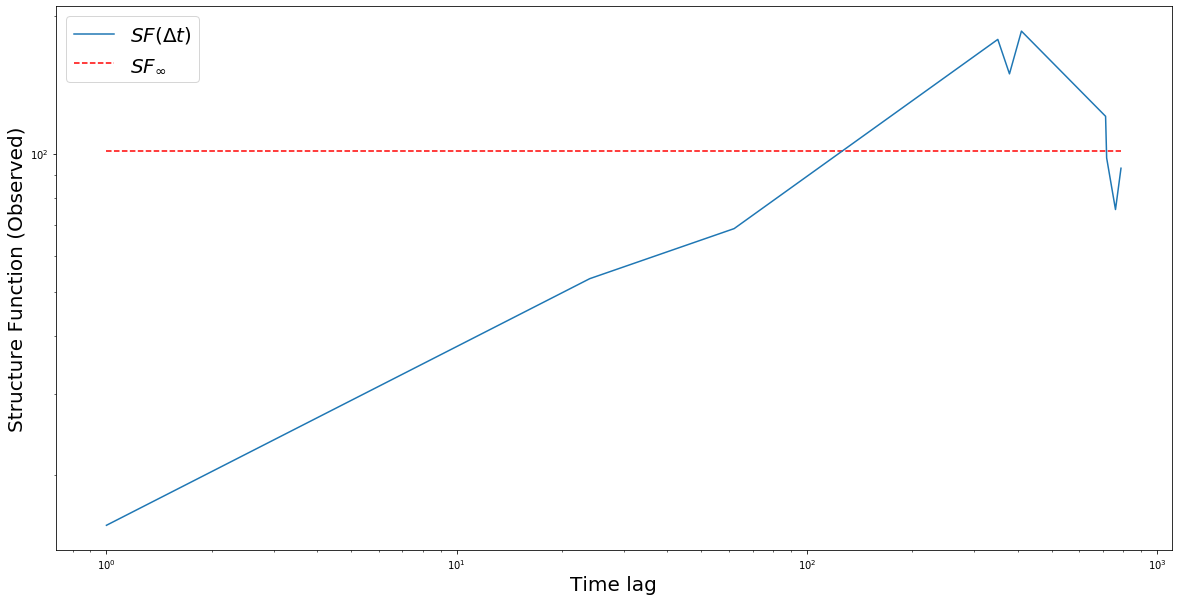

In [72]:
passband = 'g'
target = target[['mjd',passband,passband+'_err']].dropna()
obs_SF_list, delta_list = calculate_obs_SF(target['mjd'], target[passband])


2.9344254051256526


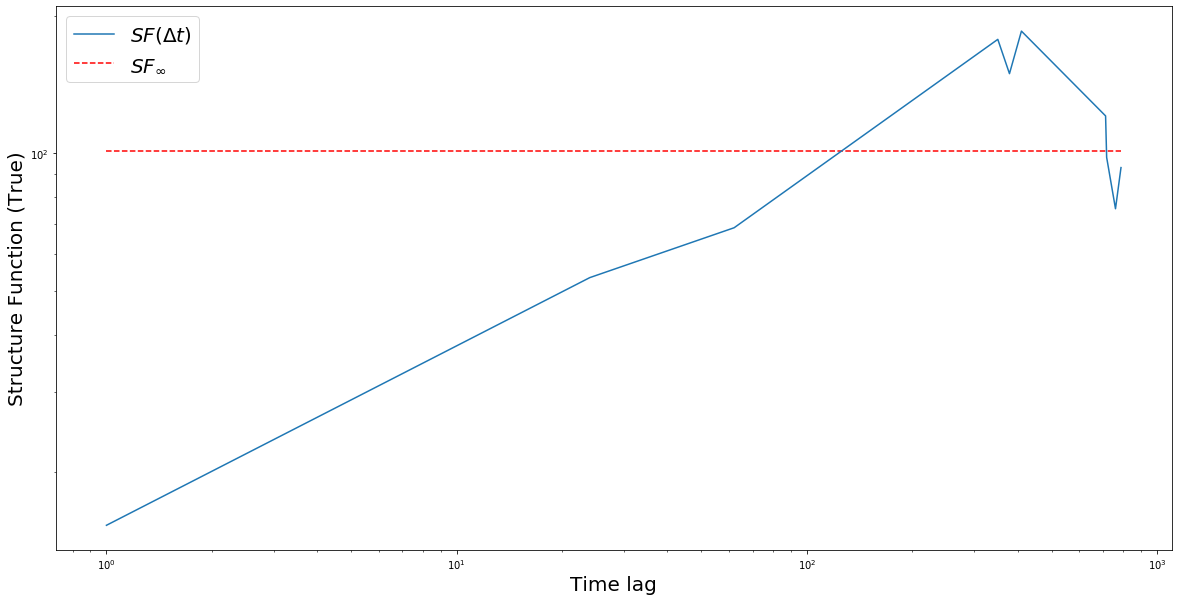

In [73]:
calculate_true_SF(obs_SF_list, delta_list, target[passband], target[passband+'_err'] )

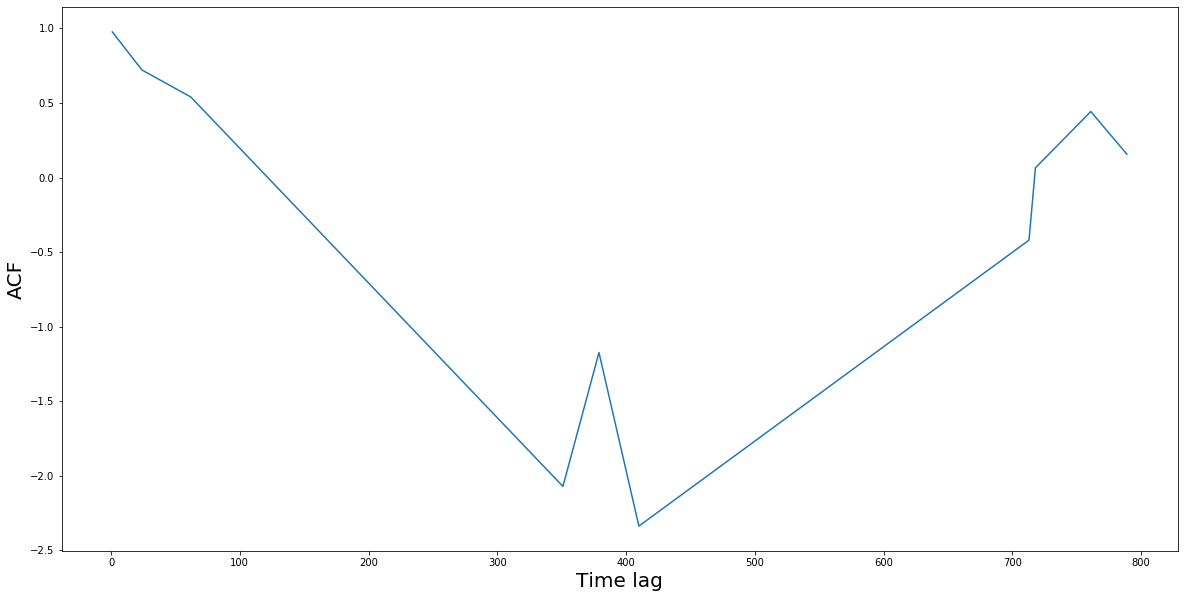

In [74]:
caculate_ACF( obs_SF_list, delta_list,target[passband],target[passband+'_err'])

/Users/sherrysheng/opt/anaconda3/envs/venv/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 11, using nperseg = 11
  .format(nperseg, input_length))


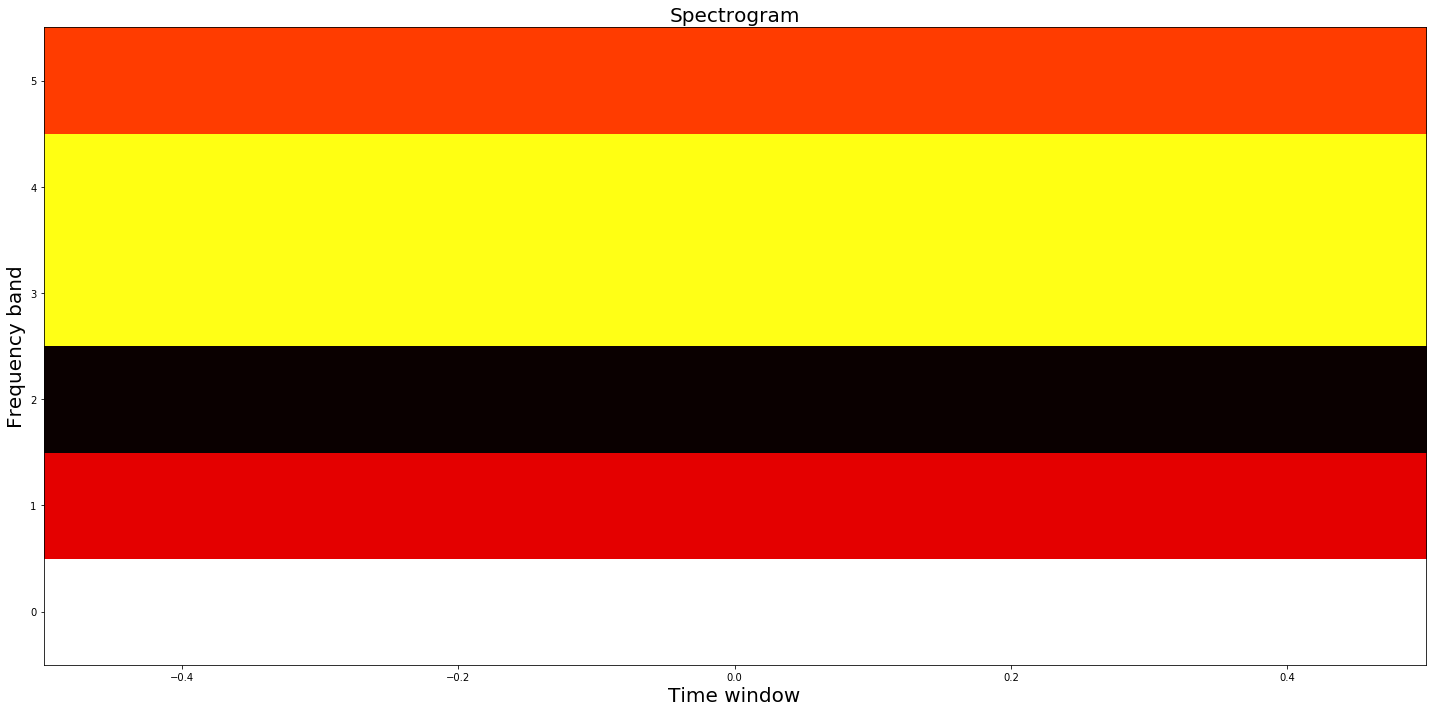

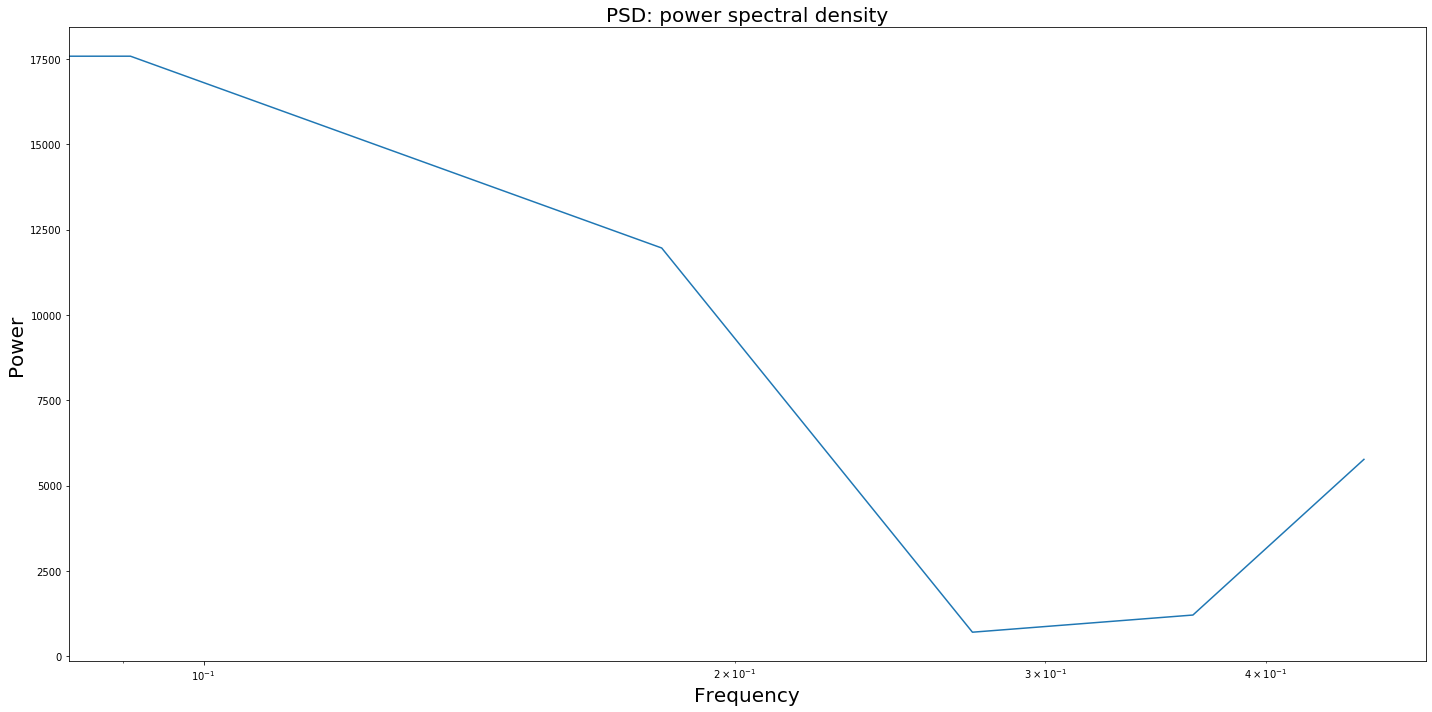

In [75]:
plot_PSD(target['mjd'], target[passband])

### After DRW simulation, calculate the simulated light curve's structure function, ACF and PSD

In [76]:
gp = GP_lc(target['mjd'], target[passband], target[passband+'_err'])
mjd = target['mjd']
band = target[passband]
continuous_mjd = np.linspace(min(mjd),max(mjd),2000)
pred_mean, pred_var = gp.predict(band, continuous_mjd, return_var=True)

Initial log likelihood: -59.06902611650574
parameter_dict:
OrderedDict([('kernel:a', 5122.382101261086), ('kernel:c', 100.0), ('mean:value', 131.7572481818182)])

parameter_names:
('kernel:a', 'kernel:c', 'mean:value')

parameter_vector:
[5122.38210126  100.          131.75724818]

parameter_bounds:
[(None, None), (None, None), (None, None)]

Final log-likelihood: -58.89726299776701
parameter_vector:
[6477.07545661   97.04623714  135.79521134]

SF infinte:  113.81630337180131
rest frame timescale:  97.04623714330178


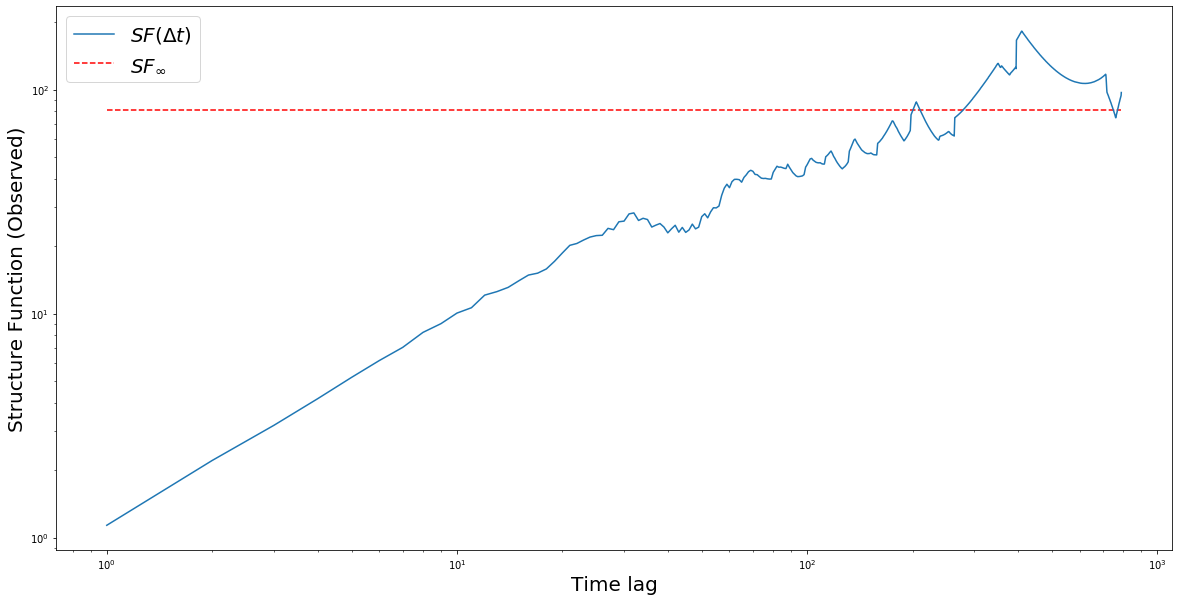

In [77]:
obs_SF_list, delta_list = calculate_obs_SF(continuous_mjd, pred_mean)

459.7450683055385


/Users/sherrysheng/opt/anaconda3/envs/venv/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)


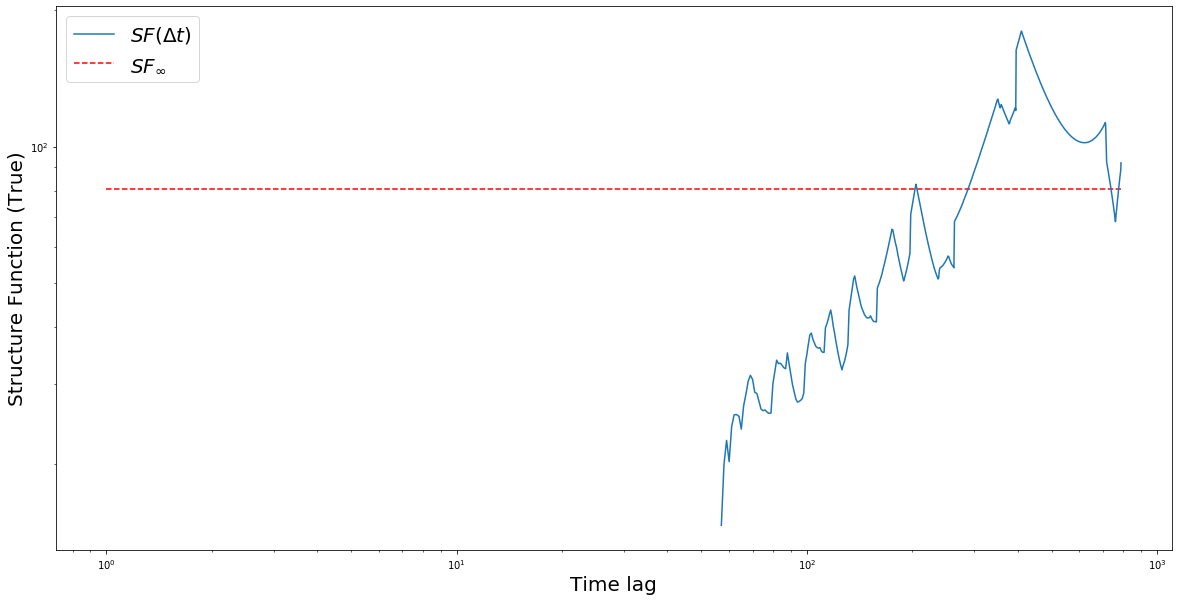

In [78]:
calculate_true_SF(obs_SF_list, delta_list, pred_mean, np.sqrt(pred_var))

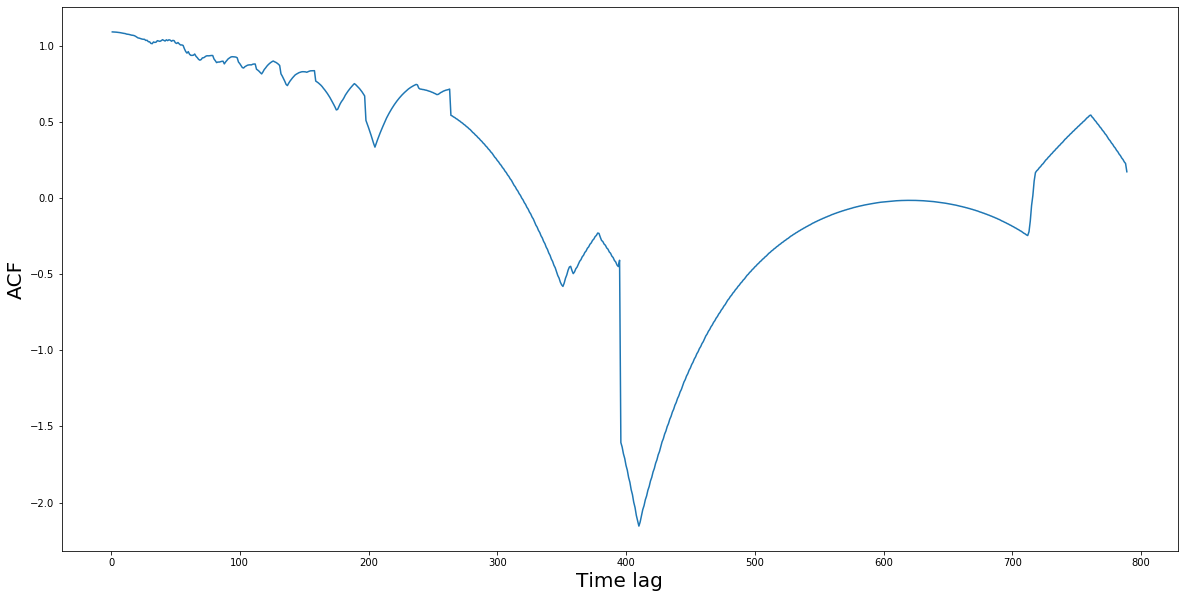

In [79]:
caculate_ACF( obs_SF_list, delta_list,target[passband],np.sqrt(pred_var))

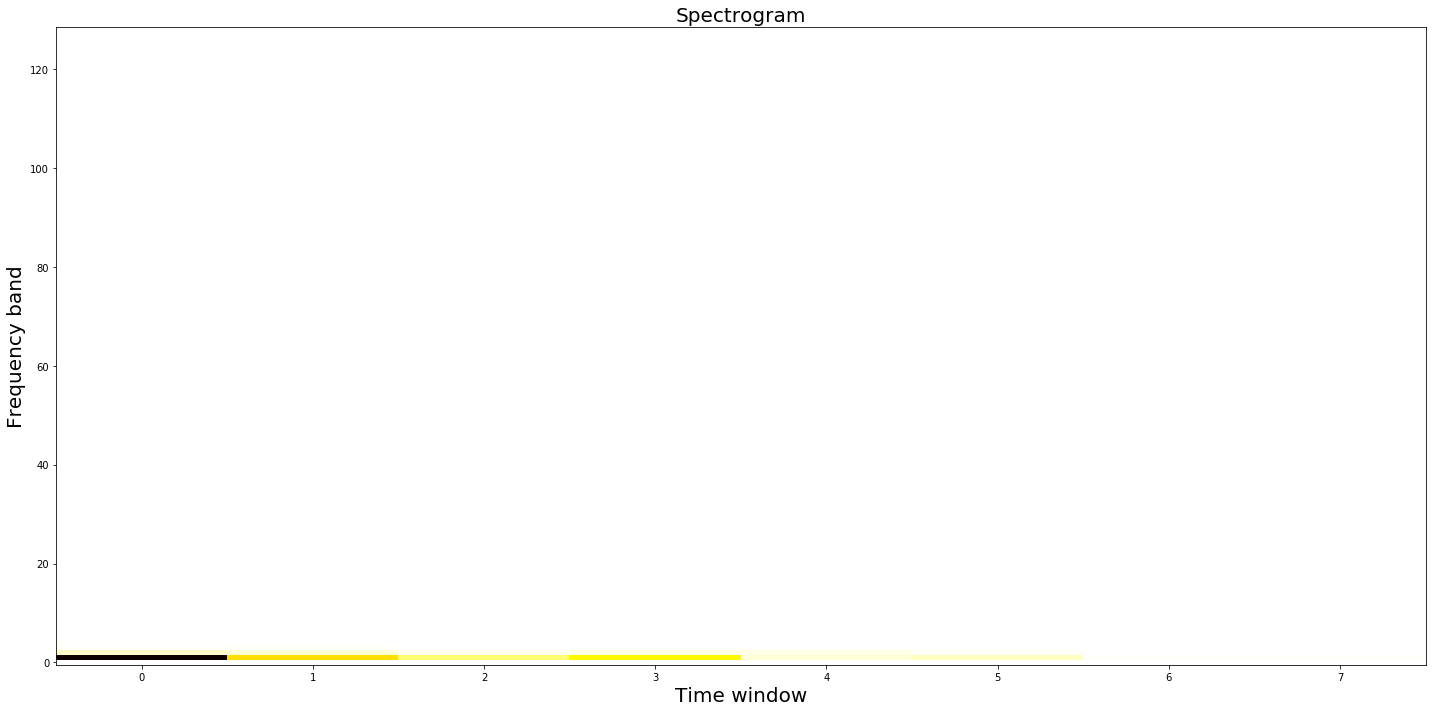

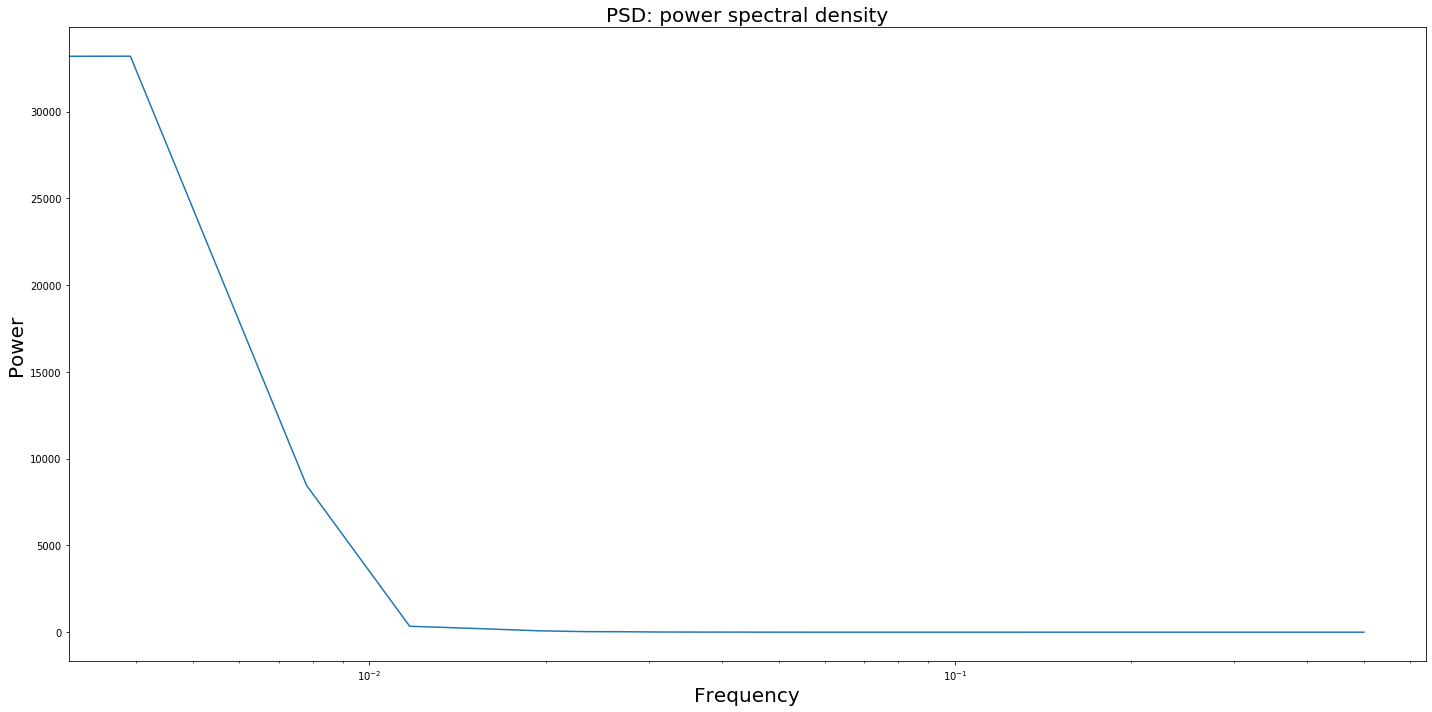

In [80]:
plot_PSD(continuous_mjd, pred_mean)